# <center>EDSA MOVIE RECOMMENDATION 2022</center>

Recommendation systems predict a user's rating or preference for an item. In this case, we are dealingn with movies from the MovieLens dataset. This recommendation system will predict what a given user will rate a movie. 

The algorithm in this notebook carries out its prediction based on similar content, or what is known as a content-based recommendation system. Given a movie that a user has not rated, the algorithm seeks to predict the rating based on the ratings given by the user on past movies. 

## Importing the data 

Explore Data Science Academy (EDSA) has provided us with 8 data files that will be used for predicting user's movie ratings. These data was resampled from the MovieLens dataset for fair evaluation. 

Our task in this section is to merge the files so as to extract the relevant properties from each file and create a dataframe that will be used in prediction. 

In [137]:
# Importing the libraries we'll use 
import numpy as np
from numpy.linalg import norm
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline
import squarify
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer


# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

## Let's import the movies data

In [13]:
movies_df = pd.read_csv('movies.csv')

In [14]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We can see that the genres properties, which is useful for our purposes, is separated by | character. We now remove the character to make it space delimited strings. 

In [15]:
movies_df['genres'] = movies_df['genres'].str.split('|').str.join(',')

In [16]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,Father of the Bride Part II (1995),Comedy


## the tags data
We'll now take a look at the tags data

In [17]:
tags_df = pd.read_csv('tags.csv')

In [18]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


From the above, we see that one user can tag a single movie more than once. We'll now examine if several users can tag the same movie

In [19]:
# searching for user tags for movie id == 1
tags_df[tags_df['movieId'] == 1]

,userId,movieId,tag,timestamp
2306,791,1,Owned,1515175493
3749,1048,1,imdb top 250,1172144394
4226,1361,1,Pixar,1216146311
10003,3164,1,Pixar,1223304727
10004,3164,1,time travel,1223304729
...,...,...,...,...
1084685,160835,1,American Animation,1437092829
1084688,160858,1,computer animation,1451035426
1084689,160858,1,pixar,1451035426
1088052,161172,1,Pixar,1159534063


From the above, we can also see that several users can tag the same movie. 

So we need a way to collect all the tags for each movie and put them in the movies_df dataframe. We also need to make sure that each tag is unique. 

In [20]:
def create_movie_tags(x):
    # get the tags list
    tags_series = tags_df[tags_df['movieId'] == x]['tag']
    # convert the series to a list
    tags_list = tags_series.tolist()
    total = []
    for letter in tags_list:
        letter = str(letter)
        intermediate = letter.split()
        total = total + intermediate
    total = list(set(total))    
    mystring = ",".join(total)
    return mystring    




In [21]:
movies_df['tags'] = movies_df['movieId'].apply(create_movie_tags)

In [22]:
movies_df.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc..."
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque..."


In [23]:
movies_df['movieId'].nunique()

62423

## Imdb data



Imdb means the Internet Movie database. it is an onliine database with information and statistics about movies. This database contains interesting properties of movies such as title cast, director, runtime, budget and plot keywords. 

In [24]:
# importing the imdb database
imdb_df = pd.read_csv('imdb_data.csv')

In [25]:
# taking a look at the database. The first five rows
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


The properties of interest from the imdb database are title_cast, director, runtime, plot_keywords. We left out the budget property for now. 

In [26]:
# removing the | character from title_cast column
imdb_df['title_cast'] = imdb_df['title_cast'].str.split('|').str.join(', ')

In [27]:
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,"Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


We now add the title_cast to the movies dataframe

In [28]:
# creating a function to add title_cast column
def add_title_cast(x):
    # create a series of the movieid column in imdb df
    title_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in title_series.values:
        title_case = imdb_df.loc[imdb_df['movieId'] == x, 'title_cast'].item()
        return title_case
    else:
        return " "         

In [29]:
movies_df['title_cast'] = movies_df['movieId'].apply(add_title_cast)
movies_df.head()

,movieId,title,genres,tags,title_cast
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


We then add the director item

In [30]:
# creating a function to add title_cast column
def add_director(x):
    # create a series of the movieid column in imdb df
    director_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in director_series.values:
        director = imdb_df.loc[imdb_df['movieId'] == x, 'director'].item()
        return director
    else:
        return " "         

In [31]:
movies_df['director'] = movies_df['movieId'].apply(add_director)

In [32]:
movies_df.head()

,movieId,title,genres,tags,title_cast,director
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett


Then add the budget

In [33]:
# creating a function to add budget column
def add_budget(x):
    # create a series of the movieid column in imdb df
    budget_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in budget_series.values:
        budget = imdb_df.loc[imdb_df['movieId'] == x, 'budget'].item()
        return budget
    else:
        return " "         

In [34]:
movies_df['budget'] = movies_df['movieId'].apply(add_budget)

In [35]:
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000"
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000"
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000"
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000"


Before adding the plot keywords, we need to remove the pipe, |, character. 

In [36]:
# removing the | character from plot_keywords column
imdb_df['plot_keywords'] = imdb_df['plot_keywords'].str.split('|').str.join(',')
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,81.0,"$30,000,000","toy,rivalry,cowboy,cgi animation"
1,2,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,104.0,"$65,000,000","board game,adventurer,fight,game"
2,3,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,101.0,"$25,000,000","boat,lake,neighbor,rivalry"
3,4,"Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,124.0,"$16,000,000","black american,husband wife relationship,betra..."
4,5,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,106.0,"$30,000,000","fatherhood,doberman,dog,mansion"


then add the plot_keywords column to movies dataframe

In [37]:
# creating a function to add plot keywords column
def add_plot_keywords(x):
    # create a series of the movieid column in imdb df
    plot_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in plot_series.values:
        plot = imdb_df.loc[imdb_df['movieId'] == x, 'plot_keywords'].item()
        plot = str(plot)
        mylist = plot.split(',')
        final_list = []
        for x in mylist:
            temp_x = x.split()
            final_list = final_list + temp_x
        final_list = list(set(final_list))
        result = ",".join(final_list)
        return result
    else:
        return " "         

In [38]:
add_plot_keywords(2)

'fight,adventurer,board,game'

In [39]:
movies_df['plot_keywords'] = movies_df['movieId'].apply(add_plot_keywords)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy,animation,rivalry,cowboy,cgi"
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","fight,adventurer,board,game"
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","neighbor,rivalry,boat,lake"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","wife,husband,betrayal,relationship,son,black,a..."
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","dog,fatherhood,doberman,mansion"


Let's add the runtime from the imdb dataframe to the movies dataframe. 

In [40]:
# creating a function to add title_cast column
def add_runtime(x):
    # create a series of the movieid column in imdb df
    runtime_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in runtime_series.values:
        runtime = imdb_df.loc[imdb_df['movieId'] == x, 'runtime'].item()
        return runtime
    else:
        return np.nan         

In [41]:
movies_df['runtime'] = movies_df['movieId'].apply(add_runtime)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy,animation,rivalry,cowboy,cgi",81.0
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","fight,adventurer,board,game",104.0
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","neighbor,rivalry,boat,lake",101.0
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","wife,husband,betrayal,relationship,son,black,a...",124.0
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","dog,fatherhood,doberman,mansion",106.0


We will create a single column that is a concatenation of the textual columns

In [42]:
movies_df['properties'] = movies_df['genres'].astype(str) + ',' + movies_df['tags'].astype(str) + ',' + movies_df['title_cast'].astype(str) + ',' + movies_df['director'].astype(str) + ',' + movies_df['plot_keywords'].astype(str) 
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy,animation,rivalry,cowboy,cgi",81.0,"Adventure,Animation,Children,Comedy,Fantasy,ar..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","fight,adventurer,board,game",104.0,"Adventure,Children,Fantasy,childhood,fantasy,f..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","neighbor,rivalry,boat,lake",101.0,"Comedy,Romance,comedinha,CLV,sequel,Meredith,b..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","wife,husband,betrayal,relationship,son,black,a...",124.0,"Comedy,Drama,Romance,chick,or,mother,revenge,C..."
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","dog,fatherhood,doberman,mansion",106.0,"Comedy,family,contraception,pregnancy,CLV,Dian..."


In [43]:
# remove non-ascii characters 
movies_df['properties'] = movies_df['properties'].str.encode('ascii', 'ignore').str.decode('ascii')
# remove non alphabetic characters, including numerics
movies_df['properties'] = movies_df['properties'].str.replace(r'[_0-9:\(\)]+', '')
# remove trailing and middle-placed white space and commas. 
movies_df['properties'] = movies_df['properties'].str.replace('[\s,]*,[\s,]*', ',', regex=True)
# convert all the string to lower case
movies_df['properties'] = movies_df['properties'].str.lower()
movies_df

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy,animation,rivalry,cowboy,cgi",81.0,"adventure,animation,children,comedy,fantasy,ar..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","fight,adventurer,board,game",104.0,"adventure,children,fantasy,childhood,fantasy,f..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","neighbor,rivalry,boat,lake",101.0,"comedy,romance,comedinha,clv,sequel,meredith,b..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","wife,husband,betrayal,relationship,son,black,a...",124.0,"comedy,drama,romance,chick,or,mother,revenge,c..."
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","dog,fatherhood,doberman,mansion",106.0,"comedy,family,contraception,pregnancy,clv,dian..."
...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,,,,,,NaN,"drama,"
62419,209159,Window of the Soul (2001),Documentary,,,,,,NaN,"documentary,"
62420,209163,Bad Poems (2018),"Comedy,Drama",,,,,,NaN,"comedy,drama,"
62421,209169,A Girl Thing (2001),(no genres listed),,,,,,NaN,"no genres listed,"


In [44]:
# remove duplicated words in each property. There are lots of duplicates
def remove_dup(x):
    mylist = x.split(',')
    final_list = []
    for y in mylist:
        temp_y = y.split()
        final_list = final_list + temp_y
    final_list = list(set(final_list))
    result = ",".join(final_list)
    return result



In [45]:
movies_df['properties'] = movies_df['properties'].apply(remove_dup)
movies_df

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","arts,first,Hanks,CLV,mission,rousing,bright,Bu...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy,animation,rivalry,cowboy,cgi",81.0,"arts,first,mission,rousing,bright,best,in,doll..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","childhood,fantasy,family,Book,CLV,horrifying,w...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","fight,adventurer,board,game",104.0,"chris,horrifying,monkey,jungle,in,bc,cgi,a,wil..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","comedinha,CLV,sequel,Meredith,best,friend,Marg...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","neighbor,rivalry,boat,lake",101.0,"meredith,comedinha,kevin,de,ann-margret,jack,s..."
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance","chick,or,mother,revenge,CLV,interracial,divorc...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","wife,husband,betrayal,relationship,son,black,a...",124.0,"whitney,wife,haysbert,black,characters,based,j..."
4,5,Father of the Bride Part II (1995),Comedy,"family,contraception,pregnancy,CLV,Diane,seque...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","dog,fatherhood,doberman,mansion",106.0,"keaton,family,fantasy,wong,contraception,pregn..."
...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,,,,,,NaN,drama
62419,209159,Window of the Soul (2001),Documentary,,,,,,NaN,documentary
62420,209163,Bad Poems (2018),"Comedy,Drama",,,,,,NaN,"drama,comedy"
62421,209169,A Girl Thing (2001),(no genres listed),,,,,,NaN,"listed,no,genres"


We will now concentrate on the two columns that have numeric values - budget and runtime. Let's see their data types

In [46]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        62423 non-null  int64  
 1   title          62423 non-null  object 
 2   genres         62423 non-null  object 
 3   tags           62423 non-null  object 
 4   title_cast     52758 non-null  object 
 5   director       52904 non-null  object 
 6   budget         44840 non-null  object 
 7   plot_keywords  62423 non-null  object 
 8   runtime        13521 non-null  float64
 9   properties     62423 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 4.8+ MB


We can see that the datatype of budget is object (string). We need to convert it to numeric. Also, budget and runtime has null values. We need to fill these nulls with 0. Also, on examining the budget columm, there are some characters like $, GBP etc. that have to be removed. 

In [47]:
# fill runtime and budget nulls with 0
movies_df['runtime'] = movies_df['runtime'].fillna(0)
movies_df['budget'] = movies_df['budget'].fillna(0)
# remove all non-numeric characters
movies_df['budget'] = movies_df['budget'].str.replace('[^0-9]+', '')
# convert budget column to numeric column
movies_df['budget'] = movies_df['budget'].apply(pd.to_numeric)
movies_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        62423 non-null  int64  
 1   title          62423 non-null  object 
 2   genres         62423 non-null  object 
 3   tags           62423 non-null  object 
 4   title_cast     52758 non-null  object 
 5   director       52904 non-null  object 
 6   budget         7283 non-null   float64
 7   plot_keywords  62423 non-null  object 
 8   runtime        62423 non-null  float64
 9   properties     62423 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.8+ MB


In [48]:
# how many movies do we have?
print("The number of books in the movies database is:", movies_df.shape[0])

The number of books in the movies database is: 62423


In [49]:
# we now create a convenient index to map between movie ids and the indices in the data frame. 
movie_idx = movies_df['movieId']
indices = pd.Series(movies_df.index, index=movies_df['movieId'])

## Movie Ratings
Let's explore the ratings database. The ratings will be used for predictions. 

In [50]:
# importing the ratings csv file
movie_ratings = pd.read_csv('train.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


We'll remove the timestamps from the ratings and then add movie titles to the ratings dataframe.

In [51]:
movie_ratings.drop("timestamp", axis=1, inplace=True)
movie_ratings.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [52]:
movie_ratings['title'] = movie_ratings.merge(movies_df, on=['movieId'], how='left')['title']
movie_ratings.head()


,userId,movieId,rating,title
0,5163,57669,4.0,In Bruges (2008)
1,106343,5,4.5,Father of the Bride Part II (1995)
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005)
4,9041,366,3.0,Wes Craven's New Nightmare (Nightmare on Elm S...


Let's do an exploratory data analysis of the ratings. 

In [53]:
# how many ratings do we have?
print("The number of ratings are", movie_ratings.shape[0])

The number of ratings are 10000038


Let's see how kind the movie viewers are to movie producers in their ratings. That is, what is the most likely rating given to a movie?

Average rating in dataset: 3.5333951730983424


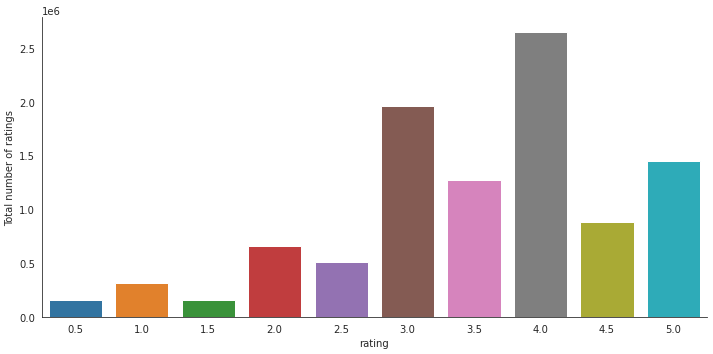

In [54]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=movie_ratings, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(movie_ratings["rating"])}')

From the above statistic and graphic, we can see that movie viewers tend to rate movies high. The mean rating is 3.5 while the modal rating is 4.0.

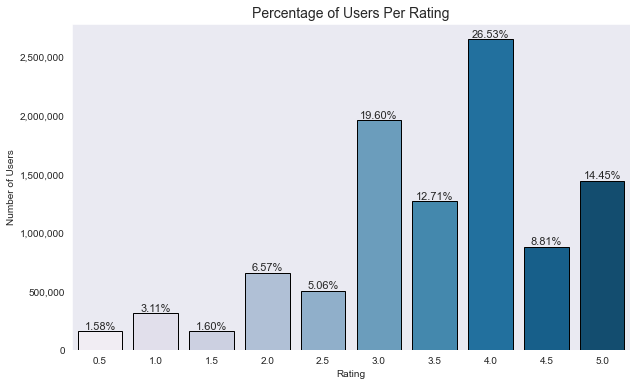

In [133]:
# create a plot showing percentage of users per rating
sub_df= movie_ratings['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=sub_df, x='index', y='rating', palette="PuBu", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(sub_df['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Percentage of Users Per Rating', fontsize=14)
plt.show()

This showed that over 60% of the users who rated gave good ratings to the movies. 

In [111]:
# Create a copy of the movie_ratings dataframe
movie_releaseyear = movie_ratings.copy()

In [113]:
# Extract release year from movie titles
movie_releaseyear['release_year']=movie_releaseyear['title'].str[-5:-1] #extracting released year

In [57]:
# Movies with the highest average ratings
movie_ratings.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Which Way Home (2009)        5.0
Kaakha Kaakha (2003)         5.0
Not Quite Human II (1989)    5.0
Selling Isobel (2018)        5.0
Sehar (2005)                 5.0
Name: rating, dtype: float64

We can see the top 5 movies with the highest average ratings but this is subjective to the number of ratings that each movie received. The hypothesis is that a good movie is one with a very high average rating even after being rated by a lot of viewers. We will therefore have to inspect the total number of ratings each movie received.

In [55]:
# Show a list of the most rated movies
movie_ratings.groupby('title')['rating'].count().sort_values(ascending = False).head

<bound method NDFrame.head of title
Shawshank Redemption, The (1994)         32831
Forrest Gump (1994)                      32383
Pulp Fiction (1994)                      31697
Silence of the Lambs, The (1991)         29444
Matrix, The (1999)                       29014
                                         ...  
Mniejsze zło (2009)                          1
Mixed Blood (1984)                           1
Mitä meistä tuli (2009)                      1
Mitch Albom's For One More Day (2007)        1
줄탁동시 (2012)                                  1
Name: rating, Length: 48151, dtype: int64>

We can see here that the most rated movies are not amongst the movies with the highest average ratings. On this regard, we concluded that a better insight on good movies can be achieved by using both average ratings and total number of ratings per movie

In [78]:
movie_rating_count = pd.DataFrame(movie_ratings.groupby('title')['rating'].mean())

In [79]:
movie_rating_count['ratings_count'] = pd.DataFrame(movie_ratings.groupby('title')['rating'].count())

In [80]:
movie_rating_count.head()

,rating,ratings_count
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


Text(0, 0.5, 'No of movies')

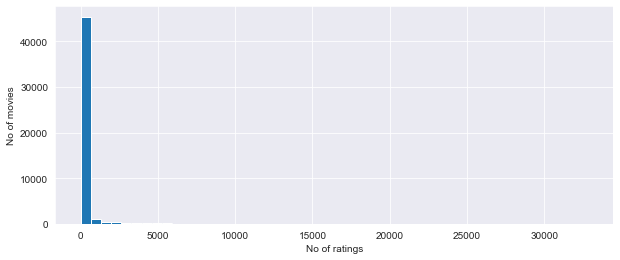

In [103]:
plt.figure(figsize =(10,4))
movie_rating_count['ratings_count'].hist(bins=50)
plt.xlabel('No of ratings')
plt.ylabel('No of movies')

This showed that most movies do not have so much rating

Text(0, 0.5, 'No of movies')

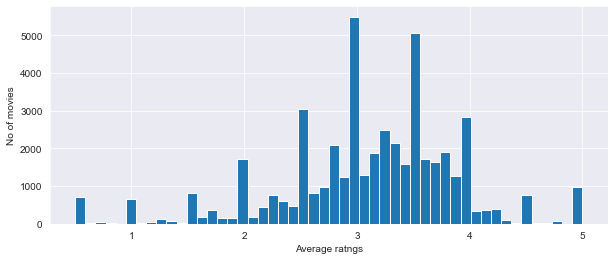

In [102]:
plt.figure(figsize =(10,4))
plt.rcParams['patch.force_edgecolor'] = True
movie_rating_count['rating'].hist(bins=50)
plt.xlabel('Average ratngs')
plt.ylabel('No of movies')

<Figure size 720x288 with 0 Axes>

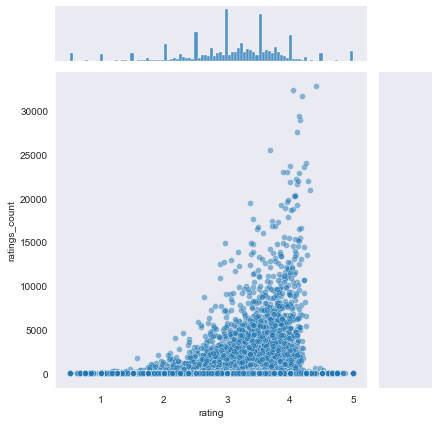

In [100]:
plt.figure(figsize=(10,4))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x= 'rating', y= 'ratings_count', data=movie_rating_count, alpha = 0.5)

This showed that most of the movies with medum to high ratings(3.5-4) had a lot of views. This implied that most movies wtih ratings around 3.5-4 were good movies to watch.

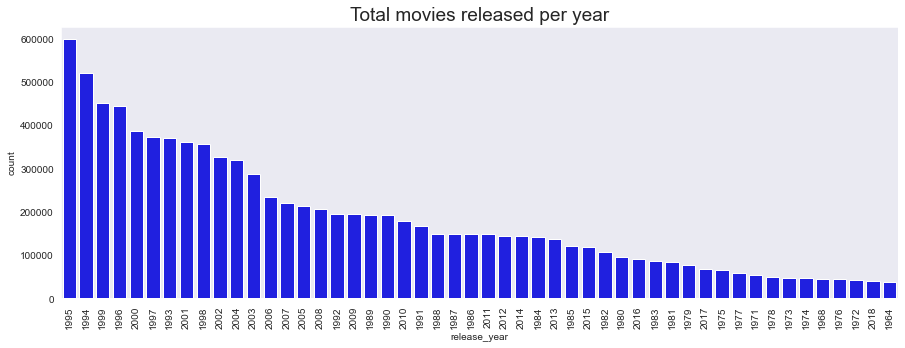

In [127]:
#Plotting total amount of movies released in each year using a count plot.
figure= plt.subplots(figsize=(15, 5))
axes=sns.countplot(x=movie_releaseyear['release_year'], order = movie_releaseyear['release_year'].value_counts()[0:50].index,color='blue')
axes.set_title('Total movies released per year',fontsize=19)
plt.xticks(rotation=90)
plt.show()

This revealed that there was a decrease in the number of movies produced in recent years

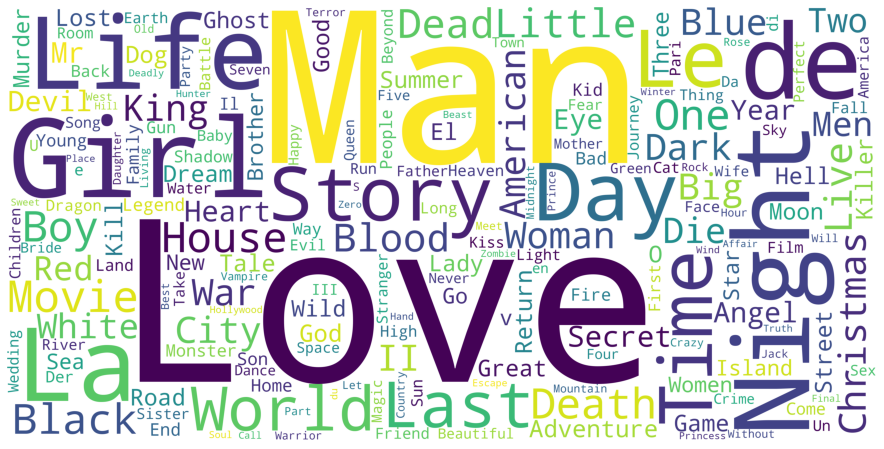

In [138]:
# Creating a wordcloud of the movie titles to view the most popular movie titles withtin the word cloud
movies_df['title'] = movies_df['title'].fillna("").astype('str')
title_corpus = ' '.join(movies_df['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plotting the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The wordcloud showed that people watched more movies with title relating to 'Love', 'Night', 'Life', 'Girl','Man', Time

## Implementation

We'll now implement a simple content-based filtering prediction system. First, we need to convert all the textual features in the movies_df properties column to numerics through vectorization. The vectorization function we will use is the TF-IDF vectorizer. It counts the frequency of words and their importance. 

In [44]:
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english', max_features = 10000)

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns 
tfidf_matrix = tf.fit_transform(movies_df['properties'])
tfidf_matrix

<62423x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1012247 stored elements in Compressed Sparse Row format>

We now have a sparse matrix with 62423 samples and 15000 features. We now convert the sparse matrix to a dataframe so we can add the budget and runtime columns. They were numeric and could not be passed to the vectorizer. 

In [45]:
sparse_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
sparse_df

,aamir,aaron,aasif,abandoned,abandonment,abbas,abbass,abbey,abbie,abbott,...,ziyi,zo,zoe,zoltan,zombie,zombies,zone,zoo,zooey,zucker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prediction

We now do the prediction. The prediction will follow the following steps:

1. We select a given user from the userid and a given movie we need the rating by that user. 
2. Collect the similarity matrix for the reference movie from that user and all other movies that has been rated by that user. 
3. Sort the collected similarity matrix in descending order
4. Select the K-highest similarity values above a given threshhold, thereby creating a k collection. 
5. Compute the weighted average rating, R, for the k-collection. The weighted average is the sum of the similarity values for each movie multiplied by the given user rating, then divided by the sum of the similarity values. When we have the startup problem (the user has not rated any movie at all), then we take the mean of all the ratings given to that movie by the public. 
6. Return the weighted average, R.


In [46]:
def estimated_rating(userid, movieid, ratings_data, k=50, threshold = 0.0):
    # convert the movieid to a numeric index for our similarity matrix
    ref_movie_idx = indices[movieid]
    neighbors = [] # our collection of similarity values is stored here
    # Gather the similarity ratings between each movie the user has rated
    # and the reference book
    user_ratings = ratings_data[ratings_data['userId'] == userid][['movieId', 'rating']] # we get a user_ratings dataframe
    # get the index of each rated movie and do the similarity value with the reference movie. Make sure the indices are not the same
    for ind in user_ratings.index:
        user_movie_idx = indices[user_ratings['movieId'][ind]]
        # get the similarity score but check whether we have same index
        # get both vectors
        if ref_movie_idx != user_movie_idx:            
            ref_vector = sparse_df.iloc[ref_movie_idx].to_numpy()
            user_vector = sparse_df.iloc[user_movie_idx].to_numpy()
            sim_score = np.dot(ref_vector, user_vector)/(norm(ref_vector)*norm(user_vector))
            rating = user_ratings['rating'][ind]
            # store sim score and rating as a tuple in neighbors list 
            neighbors.append((sim_score, rating))
    # sort the 50 largest similarity scores
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])
    
    # Compute the weighted average using similarity scores and 
    # user item ratings. 
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user. 
        # We use the average rating for the reference item as a proxy in this case 
        predictedRating = np.mean(ratings_data[ratings_data['movieId']==movieid]['rating'])
    return predictedRating
    
    
    

With our algorithm defined, let's test it out to see some of the results. 

Let's generate a rating for userid = 5163 and movie id = 57669. 

In [47]:
title = "In Brugges (2008)"
actual_rating = movie_ratings[(movie_ratings['userId'] == 5163) & (movie_ratings['movieId'] == 57669)]['rating'].values[0]
pred_rating = estimated_rating(userid=5163, movieid=57669, ratings_data=movie_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - In Brugges (2008)
---
Actual rating: 		 4.0
Predicted rating: 	 4.26590427258246


In [48]:
title = "Father of the Bride Part II (1995)"
actual_rating = movie_ratings[(movie_ratings['userId'] == 106343) & (movie_ratings['movieId'] == 5)]['rating'].values[0]
pred_rating = estimated_rating(userid=106343, movieid=5, ratings_data=movie_ratings)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Father of the Bride Part II (1995)
---
Actual rating: 		 4.5
Predicted rating: 	 3.7269579972462337


This shows us that our algorithm for predicting movie ratings is quite moderately good. We noted that the average rating is about 3.5 across all the movies with a mode of 4.0. So we can say that our rating algorithm is somewhat good overall. 

In [49]:
## Kaggle submission

In [50]:
test_df = pd.read_csv('test.csv')
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [51]:
test_df['rating'] = test_df.apply(lambda row: estimated_rating(userid=row['userId'], movieid=row['movieId'], ratings_data=movie_ratings), axis=1)
test_df.head()

KeyboardInterrupt: 